## Parsing unity VR log file

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import sep, isfile, exists
from os import mkdir, makedirs
import json

In [2]:
from unityvr.preproc import logproc
from unityvr.viz import viz

In [449]:
dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-14_16-32-28.json"#"Log_2020-8-31_19-15-6_4.json"#


dat = logproc.openUnityLog(dirName, fileName)

for i in range(3):
    print(dat[i])
    #print(dat[i]['frame'])
    #print(json.dumps(dat[i]['data'], sort_keys=True, indent=4))

{'timeSecs': 0.0, 'frame': 0.0, 'headerNotes': '-experiment:test writing photodiode signal to log -genotype:none -flyid:none -sex:none '}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera3/FlyCamera3Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 38.428314208984375, 'y': 30.339401245117188, 'z': -52.89203643798828}, 'worldRotationDegs': {'x': 0.0, 'y': 324.0, 'z': 0.0}, 'worldScale': {'x': 95.00000762939453, 'y': 182.0, 'z': 1.0}}
{'timeSecs': 0.0, 'frame': 1.0, 'meshGameObjectPath': 'Fly/FlyCamera1/FlyCamera1Screen', 'colliderType': 'MeshCollider', 'worldPosition': {'x': 0.0, 'y': 30.339401245117188, 'z': 65.37814331054688}, 'worldRotationDegs': {'x': 0.0, 'y': 180.0, 'z': 0.0}, 'worldScale': {'x': 95.0, 'y': 182.0, 'z': 1.0}}


### Construct data object from log file
#### Extract header info

In [450]:
print(dat[0]['headerNotes'])
logproc.parseHeader(dat[0]['headerNotes'])

-experiment:test writing photodiode signal to log -genotype:none -flyid:none -sex:none 


('testExp', 'test writing photodiode signal to log', 'none', 'none', 'none')

#### Pull out object positions as pandas dataframe

In [451]:
objDf = logproc.objDfFromLog(dat)
objDf.head()

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,38.428314,-52.892036,30.339401,0.0,0.0,324.0,95.000008,1.0,182.0
1,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,0.000000,65.378143,30.339401,0.0,0.0,180.0,95.000000,1.0,182.0
2,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,62.178310,20.202957,30.339401,0.0,0.0,252.0,95.000008,1.0,182.0
3,LMlocal1,CapsuleCollider,0.000000,-200.000000,27.000000,0.0,0.0,0.0,10.000000,10.0,30.0
4,LMlocal2,CapsuleCollider,300.000000,200.000000,27.000000,0.0,0.0,0.0,10.000000,10.0,30.0


#### Pull out fly position as pandas dataframe
Position in VR

In [452]:
posDf, ftDf, tsDf = logproc.timeseriesDfFromLog(dat)

In [453]:
print(len(posDf))
posDf.head()

4384


,frame,time,x,y,angle,dx,dxattempt,dy,dyattempt
0,1.0,0.000000,-0.236640,-0.368026,0.295083,-0.236640,-0.236640,-0.368026,-0.368026
1,2.0,0.020000,-0.100986,-0.499435,0.326397,0.136329,0.136329,-0.130708,-0.130708
2,3.0,0.051518,-0.040674,-0.553659,0.302967,0.060620,0.060620,-0.053880,-0.053880
3,4.0,0.058038,-0.179408,-0.511955,0.295002,-0.138953,-0.138953,0.040970,0.040970
4,5.0,0.062747,-0.179408,-0.511955,0.295002,0.000000,0.000000,0.000000,0.000000


Position based on Fictrac tracking

In [454]:
print(len(ftDf))
ftDf.head()

4414


,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,0.0,0.0,0.002624,0.000313,0.000198
1,1.0,3.0,7597044.0,-0.001960,0.001847,-0.000754
2,1.0,10.0,15194131.0,-0.001253,-0.011029,0.003062
3,1.0,18.0,22791462.0,0.002626,0.005941,0.000598
4,1.0,26.0,30388549.0,0.000441,-0.008604,0.002661


Photodiode signal and frame rate dataframe

In [455]:
print(len(tsDf))
tsDf.head()

35159


,frame,time,dt,pdsig
0,1.0,0.00,0.02,NaN
1,2.0,0.02,0.02,0.078625
2,2.0,0.02,0.02,0.079274
3,2.0,0.02,0.02,0.079274
4,2.0,0.02,0.02,0.079923


In [456]:
framesDf = tsDf[['frame','time','dt']].drop_duplicates().reset_index(level=0)[['frame','time','dt']]

In [457]:
framesDf.head()

,frame,time,dt
0,1.0,0.000000,0.020000
1,2.0,0.020000,0.020000
2,3.0,0.051518,0.031518
3,4.0,0.058038,0.006520
4,5.0,0.062747,0.004709


Fictrac updates come in at a higher rate than the VR frame rate. Fictrac can also only run for a subset of the VR run time and therefore the number of frames in fictrac and vr dataframes may not match.

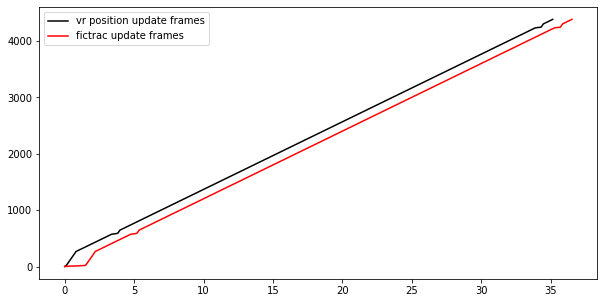

In [458]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(posDf.time, posDf.frame, 'k')
ax.plot(ftDf.ficTracTReadMs/1000, ftDf.frame, 'r')
ax.legend(['vr position update frames','fictrac update frames'])

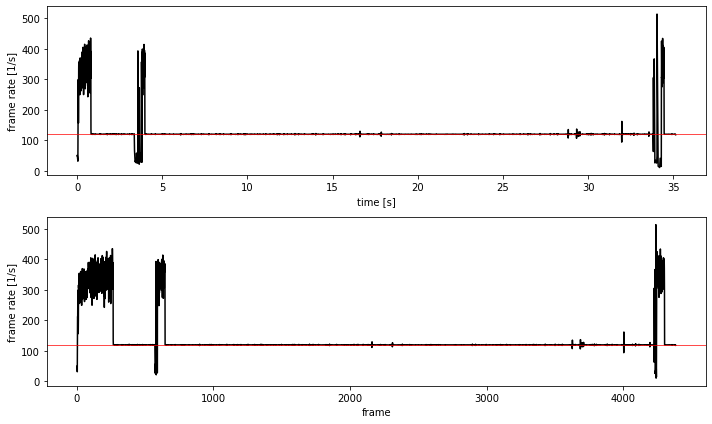

In [459]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(framesDf.time, 1/framesDf.dt, 'k')
ax[1].plot(framesDf.frame, 1/framesDf.dt, 'k')
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('frame');
for i in range(2):
    ax[i].axhline(120,0,1,color='r', linewidth=0.7)
    ax[i].set_ylabel('frame rate [1/s]')
fig.tight_layout()

if not exists(sep.join([dirName,'plots'])):
    makedirs(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','framerate_'+fileName.split('.')[0]+'.pdf']))

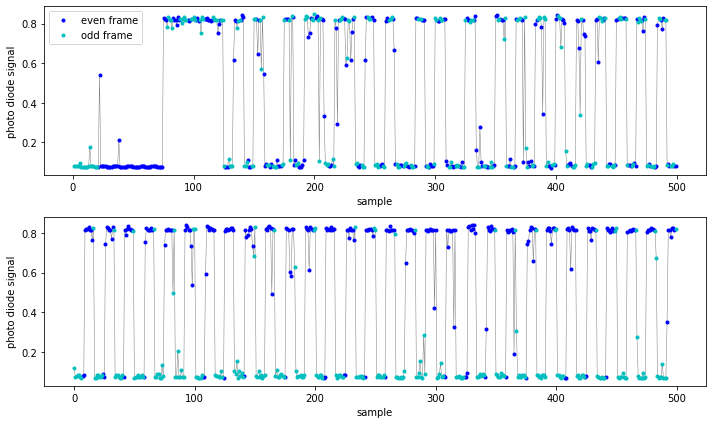

In [460]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(500),tsDf.pdsig[ts:ts+500],'-',color='grey',linewidth=0.5)
    
    even = tsDf[ts:ts+500][tsDf['frame'][ts:ts+500]%2==1]
    ax[i].plot(np.arange(500)[tsDf['frame'][ts:ts+500].values%2==1], even.pdsig, 'b.', label='even frame')
    
    odd = tsDf[ts:ts+500][tsDf['frame'][ts:ts+500]%2==0]
    ax[i].plot(np.arange(500)[tsDf['frame'][ts:ts+500].values%2==0], odd.pdsig, 'c.', label=
              'odd frame')
    
    ax[i].set_xlabel('time [s]')
    ax[i].set_ylabel('photo diode signal')
    ax[i].set_xlabel('sample');
ax[0].legend()
fig.tight_layout()

if not exists(sep.join([dirName,'plots'])):
    makedirs(sep.join([dirName,'plots']))
fig.savefig(sep.join([dirName,'plots','photodiodeSig_evenframe_'+fileName.split('.')[0]+'.pdf']))

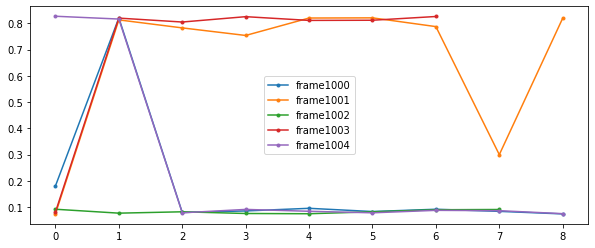

In [461]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for f in range(1000,1005):
    sig = tsDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdsig)), sig.pdsig, '.-',  label='frame{}'.format(f))
ax.legend()

Compute frame rate from photodiode signal

In [462]:
from scipy.signal import medfilt

b, a = butter(5, 0.2)
tsDf["pdFilt"]  = tsDf.pdsig.values
tsDf.pdFilt[np.isfinite(tsDf.pdsig)] = medfilt(tsDf.pdsig[np.isfinite(tsDf.pdsig)])
tsDf["pdThresh"]  = 1*(np.asarray(tsDf.pdFilt>=0.2+np.nanmedian(tsDf.pdFilt.values)))

Generate interpolated time

In [463]:
tsDf['framestart'] = np.hstack([0,1*np.diff(tsDf.time)>0])

tsDf['counts'] = 1
sampperframe = tsDf.groupby('frame').sum()[['time','dt','counts']].reset_index(level=0)
sampperframe['fs'] = sampperframe.counts/sampperframe.dt

In [464]:
from scipy import interpolate
timeAtFramestart = tsDf.time[np.where(tsDf.framestart)[0]].values
timeinterp_f = interpolate.interp1d(np.arange(len(timeAtFramestart)+1),
                                    np.hstack((timeAtFramestart,timeAtFramestart[-1]+tsDf.dt.values[-1])))
interpT = np.linspace(0, len(timeAtFramestart), len(tsDf.time))
tsDf['timeinterp'] = timeinterp_f(interpT)

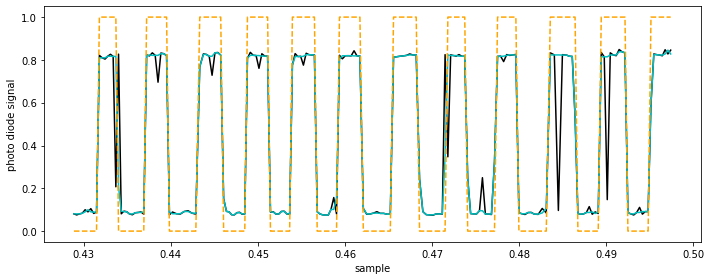

In [465]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ts = 1000
wind = 200
ax.plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdsig[ts:ts+wind], 'k')
ax.plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdFilt[ts:ts+wind], 'c')
ax.plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdThresh[ts:ts+wind], '--',color='orange')
ax.set_ylabel('photo diode signal')
ax.set_xlabel('sample');
fig.tight_layout()

(0.0, 2.0)

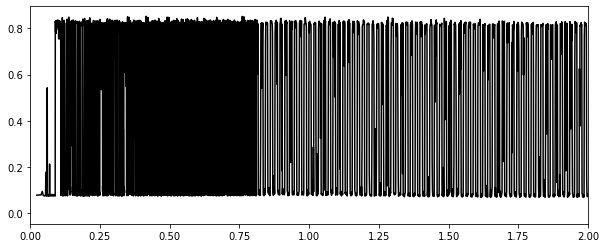

In [466]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
ax.plot(tsDf.timeinterp, tsDf.pdsig, 'k')
ax.set_xlim(0,2)

In [ ]:
# Use for loop

In [467]:
tsmDf = pd.merge(tsDf[['frame', 'time','dt','pdsig','pdThresh']], sampperframe[['frame', 'counts','fs']], on="frame", how='outer')
tsmDf

,frame,time,dt,pdsig,pdThresh,counts,fs
0,1.0,0.000000,0.020000,NaN,0,1,50.000001
1,2.0,0.020000,0.020000,0.078625,0,20,50.000001
2,2.0,0.020000,0.020000,0.079274,0,20,50.000001
3,2.0,0.020000,0.020000,0.079274,0,20,50.000001
4,2.0,0.020000,0.020000,0.079923,0,20,50.000001
...,...,...,...,...,...,...,...
35154,4384.0,35.136528,0.008438,0.205432,0,9,118.508690
35155,4384.0,35.136528,0.008438,0.206405,0,9,118.508690
35156,4384.0,35.136528,0.008438,0.205756,0,9,118.508690
35157,4384.0,35.136528,0.008438,0.206081,0,9,118.508690


93.4873465484171


<ipython-input-479-5ca2686db1a0>:9: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].plot(1/pddt, 'c')
<ipython-input-479-5ca2686db1a0>:16: RuntimeWarning: divide by zero encountered in true_divide
  ax[2].plot(1/pddt, 'c')


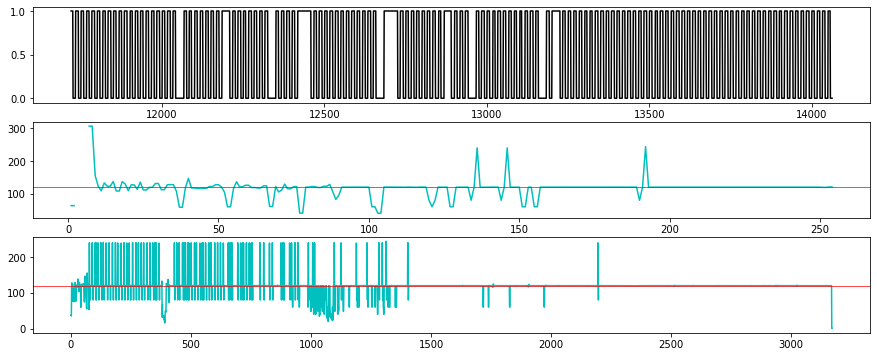

In [479]:
ts = 5*round(len(tsmDf.fs)/15)
wind = round(len(tsmDf.fs)/15)

pdDiff = np.gradient(tsmDf.pdThresh[ts:ts+wind])
pddt = np.gradient(tsmDf.time[np.where((pdDiff) > 0)[0]])

fig, ax = plt.subplots(3,1, figsize=(15,6))
ax[0].plot(tsDf.pdThresh[ts:ts+wind], 'k')
ax[1].plot(1/pddt, 'c')
ax[1].axhline(120,0,1,color='r', linewidth=0.7)

pdDiff = np.gradient(tsmDf.pdThresh)
pddt = np.gradient(tsmDf.time[np.where((pdDiff) > 0)[0]])

print(1/np.nanmean(pddt))
ax[2].plot(1/pddt, 'c')
ax[2].axhline(120,0,1,color='r', linewidth=0.7)

#### Generate data object

In [4]:
from unityvr.preproc import logproc

dirName = "../sample/framerateTest/"
fileName = "Log_2021-01-14_17-20-18.json"#"Log_2020-8-31_19-15-6_4.json"#

uvrTest = logproc.constructUnityVRexperiment(dirName,fileName)
uvrTest.printMetadata()

Metadata:

expid  :  testExp
experiment  :  test writing photodiode signal to log
genotype  :  none
sex  :  none
flyid  :  none
date  :  2021-01-14
time  :  17-20-18


In [5]:
uvrTest.saveData(dirName)

In [6]:
frameftDf = uvrTest.downsampleftDf()
frameftDf.head()

,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,1.0,267.0,2.734885e+08,-0.002734,-0.002111,-0.000381
1,2.0,345.0,3.494650e+08,-0.001913,-0.000159,0.000043
2,9.0,2411.0,2.415884e+09,-0.003989,-0.007542,0.006979
3,10.0,4656.0,4.672240e+09,0.002436,-0.000269,0.000909
4,11.0,379.0,3.798571e+08,-0.000656,-0.000560,0.000439


### ToDo: Write method to construct data class from saved files

#### Extract NIDAQ-recorded photodiode trace

In [221]:
from scipy.signal import filtfilt,  butter
  
#pdDf["pdFilt"] = savgol_filter(pdDf.pdSig, 5, 2)
# apply a 3-pole lowpass filter at 0.1x Nyquist frequency
b, a = butter(3, 0.2)
pdDf["pdFilt"]  = filtfilt(b, a, pdDf.pdSig)
pdDf["pdThresh"]  = 1*(np.asarray(pdDf.pdFilt>np.median(pdDf.pdFilt.values)))
pdDf['count'] = 1

In [259]:
pdDf = pdDfFromLog(dat)
pdDf.head()

,frame,timeSecs,pdSig,pdFilt,pdThresh
0,2.0,0.020000,0.078625,0.078985,0
1,2.0,0.020000,0.079274,0.080223,0
2,2.0,0.020000,0.079274,0.081069,0
3,2.0,0.020000,0.079923,0.081300,0
4,2.0,0.020000,0.079923,0.080795,0
...,...,...,...,...,...
35153,4384.0,35.136528,0.205432,0.197726,0
35154,4384.0,35.136528,0.206405,0.211686,0
35155,4384.0,35.136528,0.205756,0.215792,0
35156,4384.0,35.136528,0.206081,0.212671,0


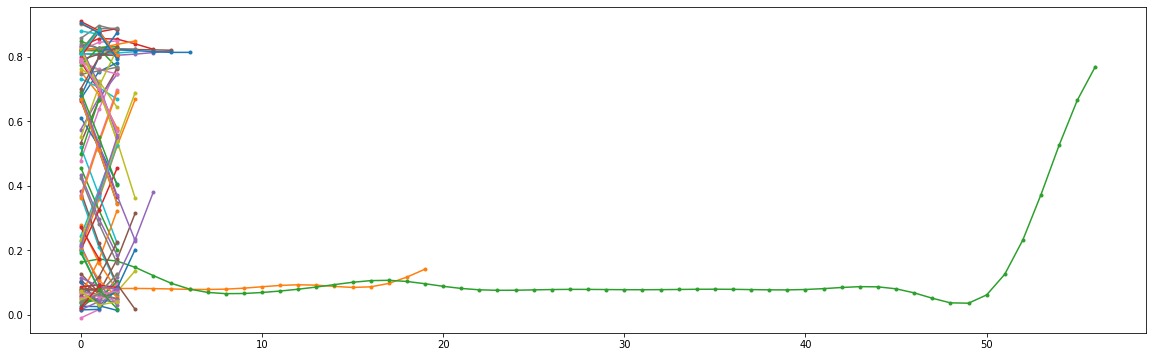

In [284]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
for f in range(1,100):
    sig = pdDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdFilt)), sig.pdFilt, '.-')

In [237]:
perframe = pdDf.groupby("frame").sum().reset_index()
perframe

,frame,timeSecs,pdSig,pdFilt,pdThresh,dframe,count
0,2.0,0.400000,1.671098,1.773761,0,0.0,20
1,3.0,2.936509,7.286311,7.057214,4,57.0,57
2,4.0,0.290190,4.033550,4.204158,5,0.0,5
3,5.0,0.376481,4.908366,4.856204,6,6.0,6
4,6.0,0.404846,4.922312,4.927751,6,0.0,6
...,...,...,...,...,...,...,...
4378,4380.0,245.721699,1.436403,1.457799,0,0.0,7
4379,4381.0,316.002811,1.013780,0.978711,0,9.0,9
4380,4382.0,280.958038,1.374600,1.402147,0,0.0,8
4381,4383.0,281.024719,0.826834,0.773462,0,8.0,8


In [238]:
pertime = pdDf.groupby("timeSecs").sum().reset_index()
pertime

,timeSecs,frame,pdSig,pdFilt,pdThresh,dframe,count
0,0.020000,40.0,1.671098,1.773761,0,0.0,20
1,0.051518,171.0,7.286311,7.057214,4,57.0,57
2,0.058038,20.0,4.033550,4.204158,5,0.0,5
3,0.062747,30.0,4.908366,4.856204,6,6.0,6
4,0.067474,36.0,4.922312,4.927751,6,0.0,6
...,...,...,...,...,...,...,...
4378,35.103100,30660.0,1.436403,1.457799,0,0.0,7
4379,35.111423,39429.0,1.013780,0.978711,0,9.0,9
4380,35.119755,35056.0,1.374600,1.402147,0,0.0,8
4381,35.128090,35064.0,0.826834,0.773462,0,8.0,8


(2.5, 6.666666666666667)

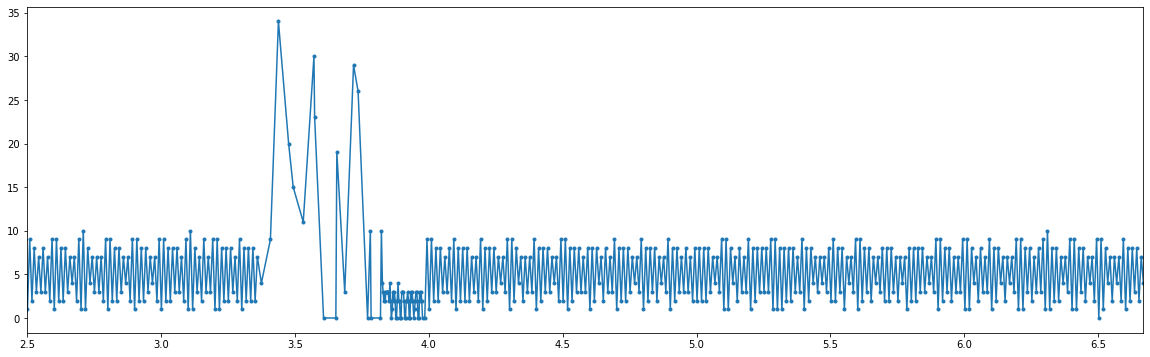

In [257]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pertime.timeSecs, pertime.pdThresh, '.-')
ax.set_xlim(300/120., 800/120.)

(300.0, 800.0)

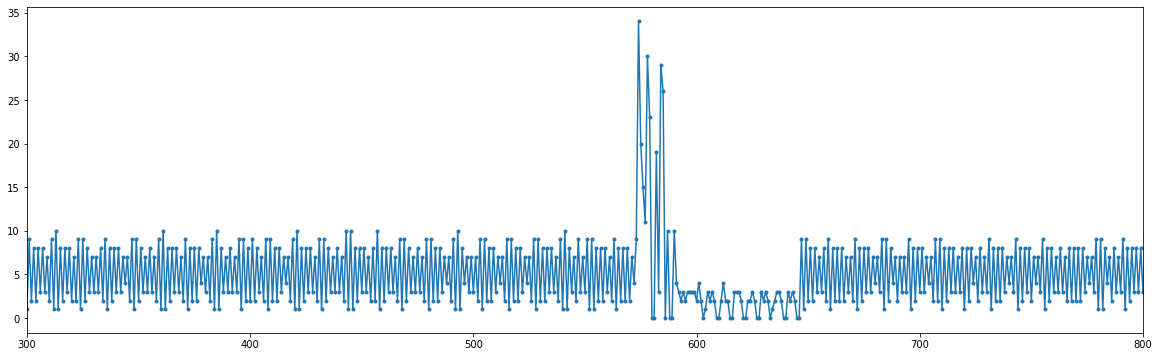

In [258]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(perframe.frame, perframe.pdThresh, '.-')
ax.set_xlim(300,800)

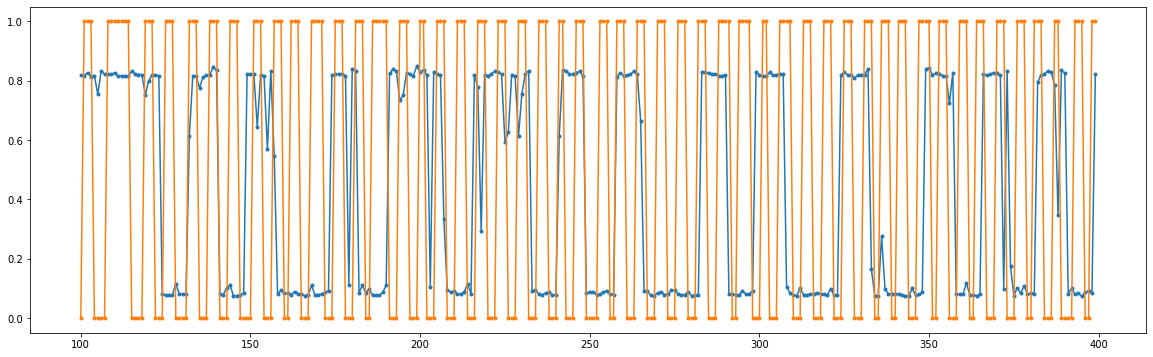

In [224]:
pdDf["dframe"] = pdDf.frame%2.

fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pdDf.pdSig[100:400], '.-')
#ax.plot(pdDf.pdFilt[100:400], '.-')
#ax.plot(pdDf.pdThresh[100:400], '.-')
ax.plot(pdDf.dframe[100:400], '.-')

In [208]:
rise = np.where(np.diff(np.asarray(pdDf.pdThresh.values))>0.1)[0]
len(rise)

1657

In [219]:
1000/8

125.0

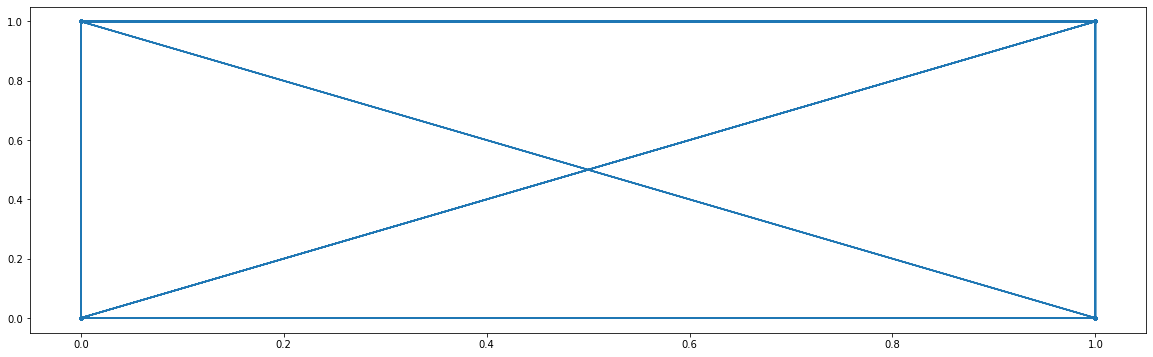

In [211]:


fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(pdDf.dframe[100:400], pdDf.pdThresh[100:400], '.-')

### Vizualize

#### Frame rate

Unity log framerate: 124.71996658445137
Fictrac log framerate: 120.84046266511533
Down sampled fictrac log framerate: 216.79983961966934


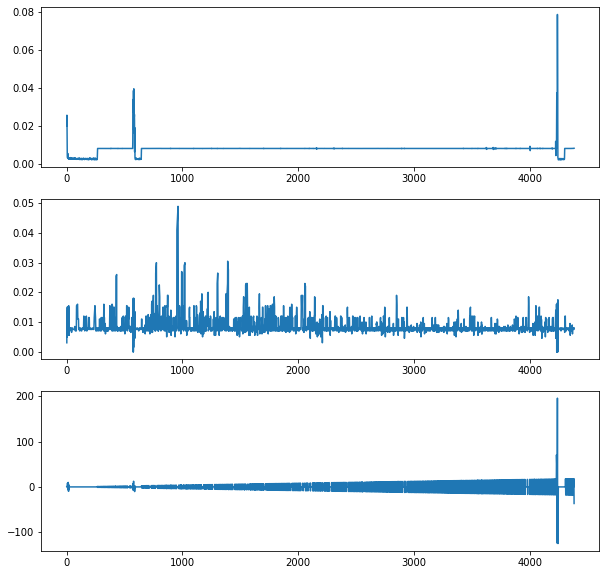

In [141]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))
axs[2].plot(uvrTest.downsampleftDf().frame,np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000.))

print('Unity log framerate: {}'.format(1/np.gradient(uvrTest.posDf.time).mean()))
print('Fictrac log framerate: {}'.format(1/np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.).mean()))
print('Down sampled fictrac log framerate: {}'.format(1/np.gradient(uvrTest.downsampleftDf().ficTracTReadMs/1000).mean()))

**Compare to fictrac data log**

In [97]:
ftlog = 'fictrac-20210113_191354.dat'
ftdat = pd.read_csv(sep.join([dirName, ftlog]), header=None)

In [108]:
ftdat.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,14257021460976,0,0,6.923518e+07
1,1,0.004147,-0.003180,0.010677,4269.942690,0.003773,0.011271,0.000188,0.004147,-0.003180,...,-0.003774,6.282997,5.960194,0.011886,0.011271,-0.003773,14257029057982,1,7597006,6.923519e+07
2,2,-0.003169,0.002485,-0.011666,4190.178400,-0.002771,-0.012003,0.000749,0.000972,-0.000702,...,-0.000996,6.282249,2.914721,0.012318,-0.000732,-0.001002,14257036655150,2,7597168,6.923520e+07
3,3,0.005476,-0.000468,0.000069,4118.660746,0.005467,0.000375,0.000436,0.006449,-0.001168,...,-0.006463,6.281813,4.780862,0.005479,-0.000357,-0.006468,14257044253662,3,7598512,6.923521e+07
4,4,-0.004719,0.000039,0.004118,3903.749013,-0.004848,0.003796,-0.001151,0.001732,-0.001118,...,-0.001618,6.282963,0.906482,0.006157,0.003439,-0.001621,14257051844806,4,7591144,6.923521e+07


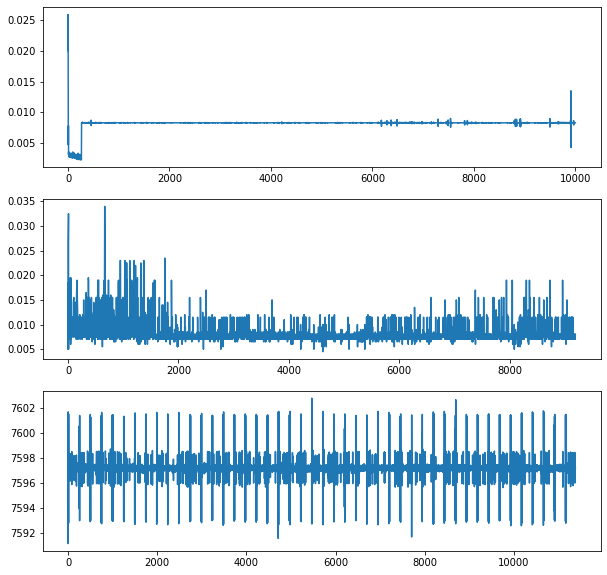

In [126]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].plot(uvrTest.posDf.frame, np.gradient(uvrTest.posDf.time))
axs[1].plot(uvrTest.ftDf.frame, np.gradient(uvrTest.ftDf.ficTracTReadMs/1000.))

ftdt = ftdat[23].values/1000.
axs[2].plot(ftdat[0].values[1:-1], ftdt[1:-1])

#### Vizualize trajectory and object positions

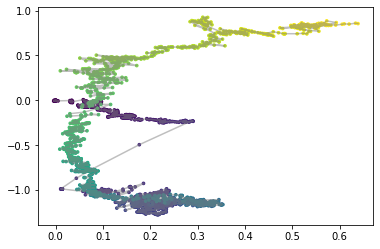

In [62]:
ballr = 45
#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

# See Seelig 2010 for reference on equations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945246/)
fta = np.cumsum(ftDf['dz'])
fty = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.cos(fta) - ballr*np.pi/180*ftDf['dx']*np.sin(fta))
ftx = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.sin(fta) + ballr*np.pi/180*ftDf['dx']*np.cos(fta))
plt.plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
plt.scatter(ftx[0:3000], fty[0:3000],s=7,c=ftDf['frame'][0:3000],cmap='viridis')

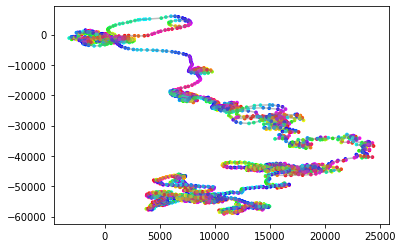

In [63]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['angle'],cmap='hsv')

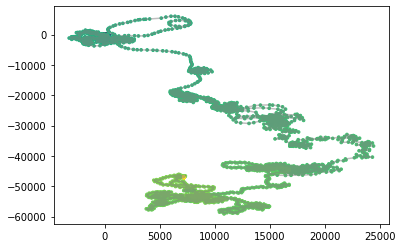

In [64]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

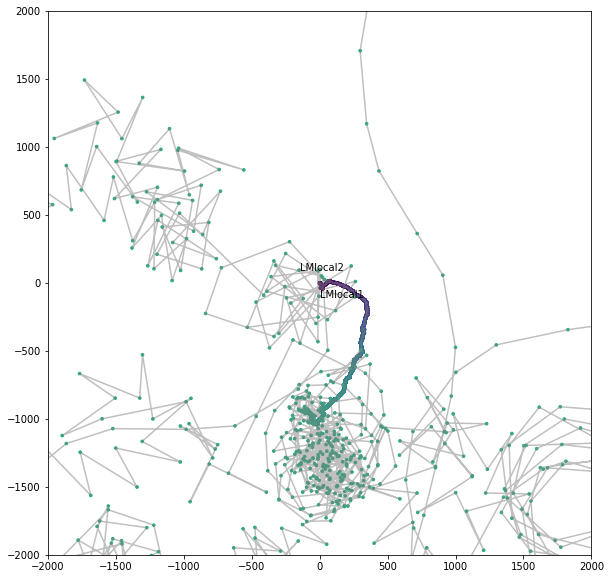

In [66]:
fig = viz.plotVRpathWithObjects(uvrTest, limx=[-2000,2000], limy=[-2000,2000],myfigsize=(10,10))